# BPI Case Study – Loan Application


## 1. Importing the Libraries 

In [ ]:
# import necessary libraries 
%pip install pandas matplotlib seaborn pm4py


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pm4py.objects.log.importer.xes.importer import apply as import_xes
from pm4py.objects.conversion.log import converter as log_converter

# seaborn 
sns.set(style='whitegrid')

# XES log dosyasını oku
log = import_xes('financial_log.xes')


# convert log to data frame
df = log_converter.apply(log, variant=log_converter.Variants.TO_DATA_FRAME)


df['time:timestamp'] = pd.to_datetime(df['time:timestamp'])

# show first lines
df.head()




Defaulting to user installation because normal site-packages is not writeable
     |█████▏                          | 1.7 MB 62 kB/s eta 0:02:255

## 2. Filtering the Noise 

parsing log, completed traces ::   0%|          | 0/13087 [00:00<?, ?it/s]

Total cases: 13087
Start activities: {'A_SUBMITTED': 13087}
End activities: {'W_Valideren aanvraag': 2747, 'W_Wijzigen contractgegevens': 4, 'A_DECLINED': 3429, 'W_Completeren aanvraag': 1939, 'A_CANCELLED': 655, 'W_Nabellen incomplete dossiers': 452, 'W_Afhandelen leads': 2234, 'W_Nabellen offertes': 1290, 'W_Beoordelen fraude': 57, 'O_CANCELLED': 279, 'A_REGISTERED': 1}
0 time cases removed. Cases left: 13087
Cases that reached a valid end (A_APPROVED / A_DECLINED / A_CANCELLED): 4084

Filtered log duration summary:
Min duration: 0 days 00:00:01.855000
Max duration: 91 days 09:55:36.161000
Average duration: 5 days 02:56:46.771978207
Variant number: 266


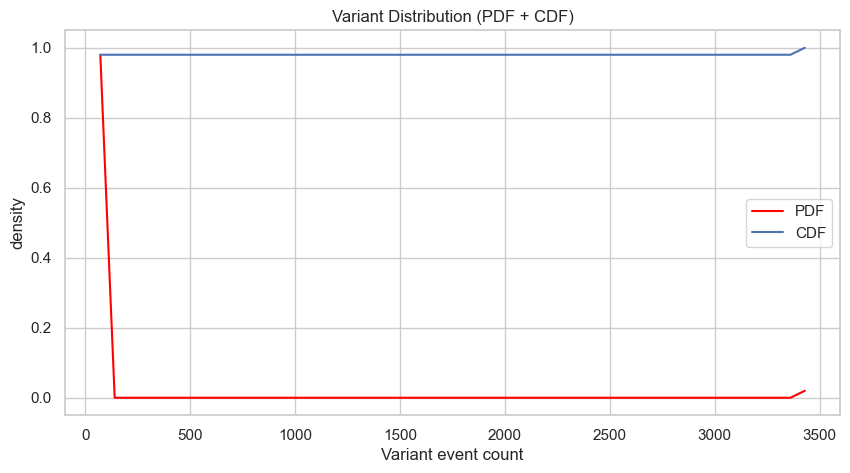

Cases left from top 50 variant: 3838
Total event: 21267


In [72]:
# necessary libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pm4py
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.conversion.log import converter as log_converter

# 1. load the data
log = xes_importer.apply("financial_log.xes")
df = log_converter.apply(log, variant=log_converter.Variants.TO_DATA_FRAME)
df['time:timestamp'] = pd.to_datetime(df['time:timestamp'])

print("Total cases:", df['case:concept:name'].nunique())
print("Start activities:", pm4py.get_start_activities(df))
print("End activities:", pm4py.get_end_activities(df))

# 2. remove 0 time cases
case_durations = df.groupby('case:concept:name').agg(
    Events=('case:concept:name', 'count'),
    First=('time:timestamp', 'min'),
    Last=('time:timestamp', 'max'),
    Duration=('time:timestamp', lambda x: x.max() - x.min())
)
zero_duration_cases = case_durations[case_durations['Duration'] == pd.Timedelta(0)].index
df = df[~df['case:concept:name'].isin(zero_duration_cases)]
print("0 time cases removed. Cases left:", df['case:concept:name'].nunique())

# 3. keep only cases that end with A_APPROVED, A_DECLINED, A_CANCELLED
valid_end_activities = ['A_APPROVED', 'A_DECLINED', 'A_CANCELLED']
filtered_df = pm4py.filter_end_activities(df, valid_end_activities)
print("Cases that reached a valid end (A_APPROVED / A_DECLINED / A_CANCELLED):", filtered_df['case:concept:name'].nunique())

# 4. duration summary
dur_summary = filtered_df.groupby('case:concept:name').agg(
    Events=('case:concept:name', 'count'),
    First=('time:timestamp', 'min'),
    Last=('time:timestamp', 'max'),
    Duration=('time:timestamp', lambda x: x.max() - x.min())
)
print("\nFiltered log duration summary:")
print("Min duration:", dur_summary['Duration'].min())
print("Max duration:", dur_summary['Duration'].max())
print("Average duration:", dur_summary['Duration'].mean())

# 5. analysing variants 
event_log = log_converter.apply(filtered_df, variant=log_converter.Variants.TO_EVENT_LOG)
variants = pm4py.get_variants(event_log)
variant_df = pd.DataFrame.from_dict({k: len(v) for k, v in variants.items()}, orient='index', columns=['Count'])
variant_df = variant_df.reset_index().rename(columns={'index': 'Variant'})
variant_df = variant_df.sort_values(by='Count', ascending=False).reset_index(drop=True)
print("Variant number:", len(variant_df))

# 6. PDF + CDF graph 
data = variant_df['Count'].head(50)
count, bins = np.histogram(data, bins=50)
pdf = count / sum(count)
cdf = np.cumsum(pdf)

plt.figure(figsize=(10, 5))
plt.plot(bins[1:], pdf, label="PDF", color='red')
plt.plot(bins[1:], cdf, label="CDF")
plt.title("Variant Distribution (PDF + CDF)")
plt.xlabel("Variant event count")
plt.ylabel("density")
plt.legend()
plt.show()

# 7. most common 50 variants 
filtered_df = pm4py.filter_variants_top_k(filtered_df, 50)
print("Cases left from top 50 variant:", filtered_df['case:concept:name'].nunique())
print("Total event:", len(filtered_df))






## 3. Redundant Activities

In [73]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt


cases = filtered_df.groupby("case:concept:name")["concept:name"].apply(list)

# transitions 
transitions = []
for activities in cases:
    transitions += list(zip(activities[:-1], activities[1:]))

transition_counts = Counter(transitions)
transition_df = pd.DataFrame(transition_counts.items(), columns=["Transition", "Count"])
transition_df = transition_df.sort_values(by="Count", ascending=False).reset_index(drop=True)

print("The most common sequential transitions:")
print(transition_df.head(10))

# co-occurence matrix
activity_sets = cases.apply(set)
activities = sorted(set(filtered_df['concept:name']))
co_matrix = pd.DataFrame(index=activities, columns=activities, data=0)


for act_set in activity_sets:
    for a in act_set:
        for b in act_set:
            if a != b:
                co_matrix.loc[a, b] += 1

# normalize 
co_matrix = co_matrix / len(activity_sets)

# more than %95
redundant_pairs = co_matrix[co_matrix > 0.95].stack().reset_index()
redundant_pairs.columns = ['Activity 1', 'Activity 2', 'Co-occurrence Ratio']
redundant_pairs = redundant_pairs[redundant_pairs['Activity 1'] != redundant_pairs['Activity 2']]

print("Activities with a co-occurrence rate of more than 95%:")
print(redundant_pairs.head(10))

# remove the redundant 
if not redundant_pairs.empty:
    redundant_activity = redundant_pairs.iloc[0]['Activity 2']
    print(f"Activity considered to be redundant: {redundant_activity}")
    filtered_df = filtered_df[filtered_df["concept:name"] != redundant_activity]
    print(f"{redundant_activity} removed.")
else:
    print("No redundant activity found. No filtering done.")

case_event_counts = filtered_df.groupby('case:concept:name')['concept:name'].nunique()
cases_to_keep = case_event_counts[case_event_counts > 0].index
filtered_df = filtered_df[filtered_df['case:concept:name'].isin(cases_to_keep)]


num_events = len(filtered_df)
num_cases = filtered_df['case:concept:name'].nunique()

print("After removing redundant activities:")
print("Number of events:", num_events)
print("Number of cases:", num_cases)


The most common sequential transitions:
                                         Transition  Count
0  (W_Completeren aanvraag, W_Completeren aanvraag)   7467
1                  (A_SUBMITTED, A_PARTLYSUBMITTED)   3838
2                   (A_PARTLYSUBMITTED, A_DECLINED)   3429
3        (W_Nabellen offertes, W_Nabellen offertes)    546
4           (A_PREACCEPTED, W_Completeren aanvraag)    409
5             (W_Completeren aanvraag, A_CANCELLED)    371
6                (A_PARTLYSUBMITTED, A_PREACCEPTED)    271
7          (W_Afhandelen leads, W_Afhandelen leads)    166
8      (W_Completeren aanvraag, W_Afhandelen leads)    138
9      (W_Afhandelen leads, W_Completeren aanvraag)    138
Activities with a co-occurrence rate of more than 95%:
          Activity 1         Activity 2  Co-occurrence Ratio
0  A_PARTLYSUBMITTED        A_SUBMITTED                  1.0
1        A_SUBMITTED  A_PARTLYSUBMITTED                  1.0
Activity considered to be redundant: A_SUBMITTED
A_SUBMITTED removed.
Aft

## 4. Case Segmentation 

In [74]:
# last activites 
last_events = filtered_df.sort_values(by="time:timestamp").groupby("case:concept:name").tail(1)


approved_cases = last_events[last_events['concept:name'] == 'A_APPROVED']['case:concept:name']
declined_cases = last_events[last_events['concept:name'] == 'A_DECLINED']['case:concept:name']
cancelled_cases = last_events[last_events['concept:name'] == 'A_CANCELLED']['case:concept:name']


approved_log = filtered_df[filtered_df['case:concept:name'].isin(approved_cases)]
declined_log = filtered_df[filtered_df['case:concept:name'].isin(declined_cases)]
cancelled_log = filtered_df[filtered_df['case:concept:name'].isin(cancelled_cases)]

# print
print("Segmented Logs:")
print(f"A_APPROVED: {len(approved_cases)} cases, {len(approved_log)} events")
print(f"A_DECLINED: {len(declined_cases)} cases, {len(declined_log)} events")
print(f"A_CANCELLED: {len(cancelled_cases)} cases, {len(cancelled_log)} events")


Segmented Logs:
A_APPROVED: 0 cases, 0 events
A_DECLINED: 3429 cases, 6858 events
A_CANCELLED: 390 cases, 10009 events


## 5. Segment Comparison 

parsing log, completed traces ::   0%|          | 0/13087 [00:00<?, ?it/s]

/var/folders/h7/36wnmbz973z0c5s0kd5byk7c0000gn/T/ipykernel_56343/1240461200.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered["Loan_Amount"] = pd.to_numeric(filtered["Loan_Amount"], errors="coerce")
/var/folders/h7/36wnmbz973z0c5s0kd5byk7c0000gn/T/ipykernel_56343/1240461200.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered["Duration"] = pd.to_numeric(filtered["Duration"], errors="coerce")
/var/folders/h7/36wnmbz973z0c5s0kd5byk7c0000gn/T/ipykernel_56343/1240461200.py:44: SettingWithCo

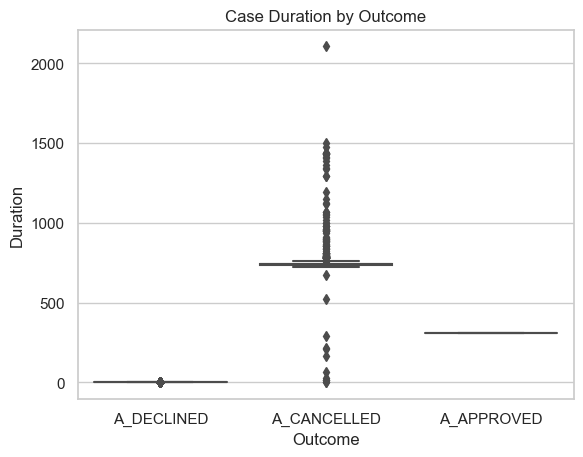

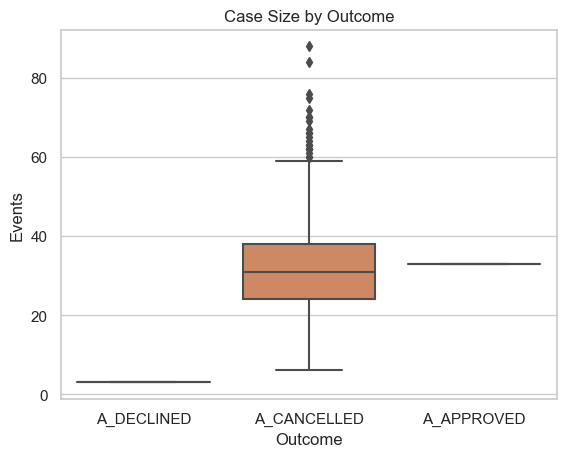

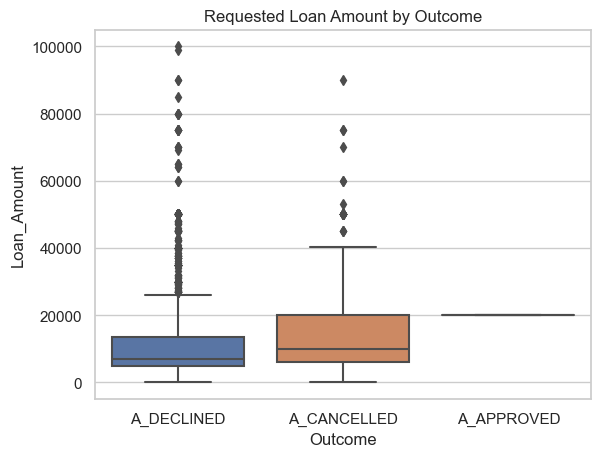

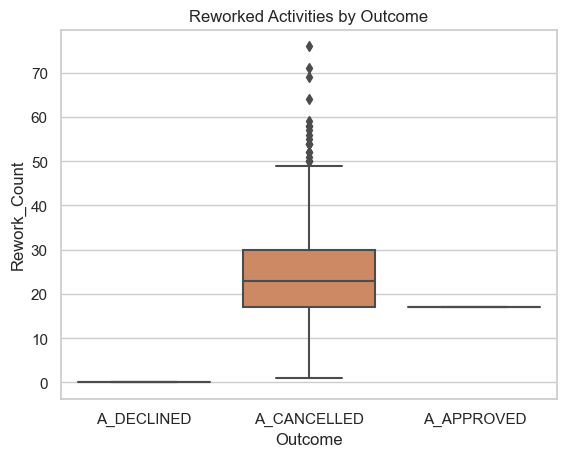

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.conversion.log import converter as log_converter

# convert log to dataframe
log = xes_importer.apply("financial_log.xes")
df = log_converter.apply(log, variant=log_converter.Variants.TO_DATA_FRAME)
df["time:timestamp"] = pd.to_datetime(df["time:timestamp"])

# Outcome segmentasyonu 
last_events = df.sort_values("time:timestamp").groupby("case:concept:name").tail(1)
approved_cases = last_events[last_events["concept:name"] == "A_APPROVED"]["case:concept:name"]
declined_cases = last_events[last_events["concept:name"] == "A_DECLINED"]["case:concept:name"]
cancelled_cases = last_events[last_events["concept:name"] == "A_CANCELLED"]["case:concept:name"]

df["Outcome"] = df["case:concept:name"].apply(
    lambda x: "A_APPROVED" if x in approved_cases.values else (
        "A_DECLINED" if x in declined_cases.values else (
            "A_CANCELLED" if x in cancelled_cases.values else "OTHER"
        )
    )
)


case_stats = df.groupby("case:concept:name").agg(
    Events=("concept:name", "count"),
    Start=("time:timestamp", "min"),
    End=("time:timestamp", "max"),
    Outcome=("Outcome", "first"),
    Loan_Amount=("case:AMOUNT_REQ", "first")  
)

# duration 
case_stats["Duration"] = (case_stats["End"] - case_stats["Start"]).dt.total_seconds() / 3600
case_stats["Rework_Count"] = df.groupby("case:concept:name")["concept:name"].apply(lambda x: x.duplicated().sum())

filtered = case_stats[case_stats["Outcome"].isin(["A_APPROVED", "A_DECLINED", "A_CANCELLED"])]


filtered["Loan_Amount"] = pd.to_numeric(filtered["Loan_Amount"], errors="coerce")
filtered["Duration"] = pd.to_numeric(filtered["Duration"], errors="coerce")
filtered["Events"] = pd.to_numeric(filtered["Events"], errors="coerce")
filtered["Rework_Count"] = pd.to_numeric(filtered["Rework_Count"], errors="coerce")

# visualization 
sns.set(style="whitegrid")

plt.figure()
sns.boxplot(data=filtered, x="Outcome", y="Duration")
plt.title("Case Duration by Outcome")
plt.show()

plt.figure()
sns.boxplot(data=filtered, x="Outcome", y="Events")
plt.title("Case Size by Outcome")
plt.show()

plt.figure()
sns.boxplot(data=filtered, x="Outcome", y="Loan_Amount")
plt.title("Requested Loan Amount by Outcome")
plt.show()

plt.figure()
sns.boxplot(data=filtered, x="Outcome", y="Rework_Count")
plt.title("Reworked Activities by Outcome")
plt.show()


## 6. Complications

parsing log, completed traces ::   0%|          | 0/13087 [00:00<?, ?it/s]

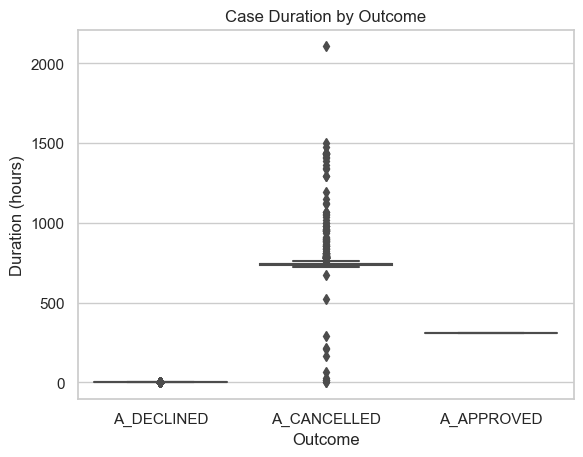

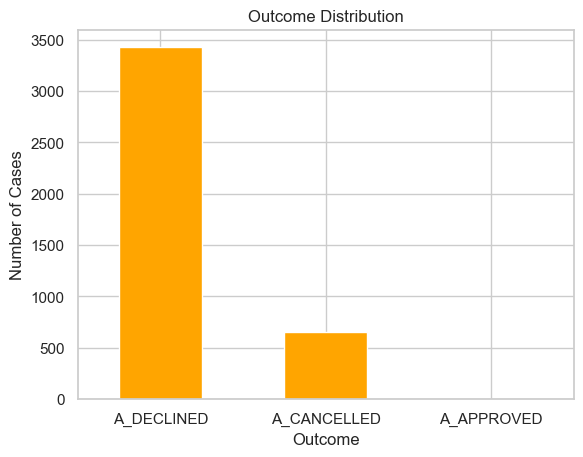

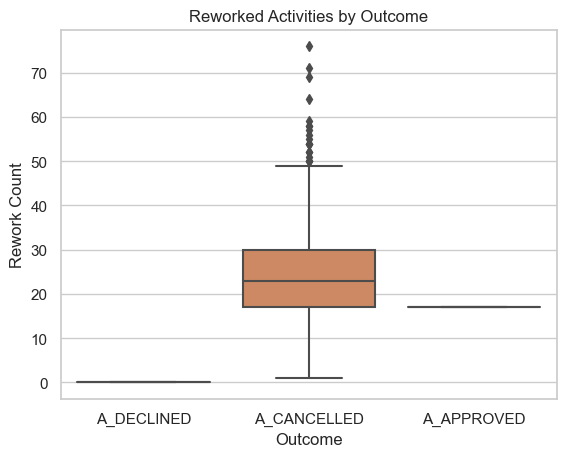

Outcome Distribution (%):
Outcome
A_DECLINED     83.98
A_CANCELLED    15.99
A_APPROVED      0.02
Name: proportion, dtype: float64

Average Case Duration (hours):
Outcome
A_APPROVED     308.99
A_CANCELLED    762.26
A_DECLINED       0.01
Name: Duration_Hours, dtype: float64

Average Rework Count:
Outcome
A_APPROVED     17.00
A_CANCELLED    23.98
A_DECLINED      0.00
Name: Rework_Count, dtype: float64


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.conversion.log import converter as log_converter

# load and convert the log
log = xes_importer.apply("financial_log.xes")
df = log_converter.apply(log, variant=log_converter.Variants.TO_DATA_FRAME)
df["time:timestamp"] = pd.to_datetime(df["time:timestamp"])

# determine outcome based on last event per case
last_events = df.sort_values("time:timestamp").groupby("case:concept:name").tail(1)
approved_cases = last_events[last_events["concept:name"] == "A_APPROVED"]["case:concept:name"]
declined_cases = last_events[last_events["concept:name"] == "A_DECLINED"]["case:concept:name"]
cancelled_cases = last_events[last_events["concept:name"] == "A_CANCELLED"]["case:concept:name"]

df["Outcome"] = df["case:concept:name"].apply(
    lambda x: "A_APPROVED" if x in approved_cases.values else (
        "A_DECLINED" if x in declined_cases.values else (
            "A_CANCELLED" if x in cancelled_cases.values else "OTHER"
        )
    )
)

# aggregate case statistics
case_stats = df.groupby("case:concept:name").agg(
    Events=("concept:name", "count"),
    Start=("time:timestamp", "min"),
    End=("time:timestamp", "max"),
    Outcome=("Outcome", "first"),
    Loan_Amount=("case:AMOUNT_REQ", "first")
)
case_stats["Duration_Hours"] = (case_stats["End"] - case_stats["Start"]).dt.total_seconds() / 3600
case_stats["Rework_Count"] = df.groupby("case:concept:name")["concept:name"].apply(lambda x: x.duplicated().sum())

# filter outcomes of interest
filtered_stats = case_stats[case_stats["Outcome"].isin(["A_APPROVED", "A_DECLINED", "A_CANCELLED"])]

# visualizations
sns.set(style="whitegrid")

plt.figure()
sns.boxplot(data=filtered_stats, x="Outcome", y="Duration_Hours")
plt.title("Case Duration by Outcome")
plt.ylabel("Duration (hours)")
plt.show()

plt.figure()
filtered_stats["Outcome"].value_counts().plot(kind="bar", color="orange")
plt.title("Outcome Distribution")
plt.ylabel("Number of Cases")
plt.xticks(rotation=0)
plt.show()

plt.figure()
sns.boxplot(data=filtered_stats, x="Outcome", y="Rework_Count")
plt.title("Reworked Activities by Outcome")
plt.ylabel("Rework Count")
plt.show()

# print statistical summaries
print("Outcome Distribution (%):")
print(filtered_stats["Outcome"].value_counts(normalize=True).mul(100).round(2))

print("\nAverage Case Duration (hours):")
print(filtered_stats.groupby("Outcome")["Duration_Hours"].mean().round(2))

print("\nAverage Rework Count:")
print(filtered_stats.groupby("Outcome")["Rework_Count"].mean().round(2))


Does the Project Minimizes Complications?

1- Outcome Distribution

A_Declined %83.98 -> very high rejection rate
A_Approved %0.002 -> almost no approvals 

The rejection rate is extremely high. 
-> Receiving any unqualified applications,
-> Rejecting even valid applications becaue of strict rules.

Conclusion: The process does not minimize rejection complications

2- Case duration

A_CANCELLED: 762.26 hours (avg)
A_APPROVED: 388.99 hours (avg)
A_DECLINED: 0.01 hours (avg)

Declined calls are processed instantly
Cancelled and approved cases take a long time, meaning the process spends hundreds of hours even when the loan is not granted.

Conclusion: The process suffers from significant delays, especially for non-declined cases.

3- Rework Activities

A_CANCELLED cases show higher rework count (some over 70).
A_DECLINED cases have minimal rework.

High rework on cancelled cases means the bank invests effort on loans that are eventually abandoned, which is inefficient.

Conclusion: There is unnecessary rework for processes that are canceled. 



## 7. Improvements

### 1- Very High Rejection Rate (A_DECLINED):

These cases contains almost the %84 of the dataset and are processed almost instantly.

Improvement suggestions:

1- Implement advanced automotic pre-screening to reduce the work of employees.

2- Add smart input validation in the loan request form to filter out ineligible applications before submission.

3- Feedback mechanisms after application rejections to avoid same cases over and over again 


### 2- Cancelled applications take so much time:

These cases consume significant time and resources and result in no final approval.

Improvement suggestions:

1- Set timeout thresholds and automatically cancel applications after a certain time

2- Consider reordering process steps so critical validations are done earlier. 

### 3- High Rework

Cancelled cases show high work.

Improvement suggestions:

1- Automate checks for incomplete submissions before progressing the applicaiton. 

2- Redesign activity flow to avoid unnecessary return and corrections. 







